In [52]:
!pip install matplotlib

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cleaned_dataset.csv')

df.dtypes

card_name               object
f1                      object
f1_sig_strike_per      float64
f1_sig_strike_total      int64
f1_td_attempt            int64
f1_td_succeed            int64
f2                      object
f2_sig_strike_per      float64
f2_sig_strike_total      int64
f2_td_attempt            int64
f2_td_succeed            int64
fights_location         object
round_format             int64
round_fought             int64
weight_class            object
winner                   int64
winning_method          object
fight_year               int64
SApM_f1                float64
SLpM_f1                float64
height_f1              float64
reach_f1               float64
stance_f1               object
strAcc_f1              float64
strDef_f1              float64
subAvg_f1              float64
tdAcc_f1               float64
tdAvg_f1               float64
tdDef_f1               float64
weight_f1                int64
born_year_f1             int64
win_f1                   int64
lose_f1 

In [3]:
# remove fight location and card name as it will probably not carry much meaning
df = df.drop(['fights_location', 'card_name'], axis=1)


In [4]:
# encode inputs of object type

encoder = LabelEncoder()
encoded_1 = df['weight_class']
encoded_1 = encoder.fit_transform(encoded_1)

encoded_2 = df['stance_f1']
encoded_2 = encoder.fit_transform(encoded_2)

encoded_3 = df['stance_f2']
encoded_3 = encoder.fit_transform(encoded_3)


In [5]:
encoded_1 = pd.DataFrame(encoded_1, columns=['weight_class'])
encoded_2 = pd.DataFrame(encoded_2, columns=['stance_f1'])
encoded_3 = pd.DataFrame(encoded_3, columns=['stance_f2'])


In [6]:
df[['weight_class']] = encoded_1[['weight_class']]
df[['stance_f1']] = encoded_2[['stance_f1']]
df[['stance_f2']] = encoded_3[['stance_f2']]


In [7]:
df = pd.concat([df,pd.get_dummies(df['winning_method'], prefix='winning_method')],axis=1)
df.drop(['winning_method'], axis=1, inplace=True)

In [8]:
df.head()

,f1,f1_sig_strike_per,f1_sig_strike_total,f1_td_attempt,f1_td_succeed,f2,f2_sig_strike_per,f2_sig_strike_total,f2_td_attempt,f2_td_succeed,...,f2_age_when_fight,winning_method_CNC,winning_method_DQ,winning_method_KO/TKO,winning_method_M-DEC,winning_method_Other,winning_method_Overturned,winning_method_S-DEC,winning_method_SUB,winning_method_U-DEC
0,Gustavo Lopez,0.60,43,3,2,Anthony Birchak,0.42,40,0,0,...,34,0,0,0,0,0,0,0,1,0
1,Jason Witt,0.20,5,0,0,Cole Williams,0.64,31,3,2,...,37,0,0,0,0,0,0,0,1,0
2,Justin Ledet,0.57,38,0,0,Dustin Jacoby,0.32,31,0,0,...,32,0,0,1,0,0,0,0,0,0
3,Miles Johns,0.45,105,7,0,Kevin Natividad,0.24,137,1,0,...,27,0,0,1,0,0,0,0,0,0
4,Louis Cosce,0.48,206,9,1,Sasha Palatnikov,0.52,237,1,1,...,31,0,0,1,0,0,0,0,0,0


In [9]:
encode = df[['f1', 'f2', 'weight_class']].apply(encoder.fit_transform)
encode.head()

,f1,f2,weight_class
0,596,104,0
1,717,328,9
2,890,476,5
3,1183,950,0
4,1004,1459,9


In [10]:
df[['f1', 'f2', 'weight_class']] = encode[['f1', 'f2', 'weight_class']]

<AxesSubplot:>

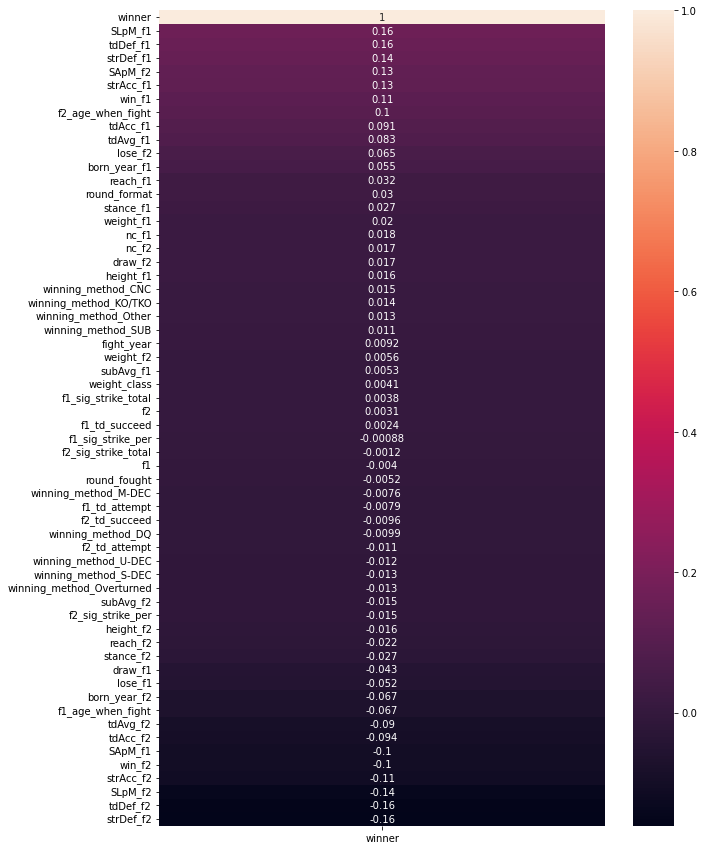

In [11]:
# look at correlation heatmap
plt.figure(figsize=(10,15))
sns.heatmap(df.corr()[['winner']].sort_values(by='winner', ascending=False), annot=True)


In [12]:
# drop unecessary column for predicting
df_shorten = df.drop(['round_fought', 'fight_year'], axis=1)

In [13]:
# normalize data
data = df_shorten.drop(['f1','f2','weight_class','round_format',
                     'winner', 'stance_f1', 'stance_f2'], axis=1)

std = StandardScaler()
df_num = data.select_dtypes(include=[np.float, np.int])

data[list(df_num.columns)] = std.fit_transform(data[list(df_num.columns)])

<ipython-input-13-5dd18de68e6e>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_num = data.select_dtypes(include=[np.float, np.int])
<ipython-input-13-5dd18de68e6e>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_n

In [14]:
df_shorten.head()

,f1,f1_sig_strike_per,f1_sig_strike_total,f1_td_attempt,f1_td_succeed,f2,f2_sig_strike_per,f2_sig_strike_total,f2_td_attempt,f2_td_succeed,...,f2_age_when_fight,winning_method_CNC,winning_method_DQ,winning_method_KO/TKO,winning_method_M-DEC,winning_method_Other,winning_method_Overturned,winning_method_S-DEC,winning_method_SUB,winning_method_U-DEC
0,596,0.60,43,3,2,104,0.42,40,0,0,...,34,0,0,0,0,0,0,0,1,0
1,717,0.20,5,0,0,328,0.64,31,3,2,...,37,0,0,0,0,0,0,0,1,0
2,890,0.57,38,0,0,476,0.32,31,0,0,...,32,0,0,1,0,0,0,0,0,0
3,1183,0.45,105,7,0,950,0.24,137,1,0,...,27,0,0,1,0,0,0,0,0,0
4,1004,0.48,206,9,1,1459,0.52,237,1,1,...,31,0,0,1,0,0,0,0,0,0


## Modeling XGBoost

### all default hyperparameter of XGBosst

In [14]:
model = XGBClassifier()
X = df_shorten.drop(['winner'], axis=1)
y = df_shorten['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
model.fit(X_train, y_train)

D:\conda\envs\analytic\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
pred = model.predict(X_test)

In [18]:
Score = model.score(X_test,y_test)
print("Score: {:.2f}".format(Score * 100.0))

Score: 74.18


## Hyperparameter tuning

In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [16]:
xgb = XGBClassifier(random_state=2)

In [18]:
# make sure the data is stratified properly if needed
# we already ensure this in preprocessing data step. But as a good practice
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [19]:
# score the base line model again, this time using cross_val_score
scores = cross_val_score(xgb, X, y, cv=kfold)
print('Accuracy:', np.round(scores, 2))
print('Accuracy mean: {:.2f}'.format(scores.mean()))

[14:26:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:26:59] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:01] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

with cross_val_score, we recalculate the base model and we have a starting point of 71%. We will look into improve the model via different hyperparameter tuning method. We will first create a function to easily conduct these search

In [20]:
# create a function taht allow us to do both grid_search and RandomizedSearchCV
def grid_search(params, random=False):
    xgb = XGBClassifier(random_state=2)
    if random:
        grid= RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1)
    else:
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    grid.fit(X,y)
        
    best_params = grid.best_params_
    print("Best params: ", best_params)
    
    best_score = grid.best_score_
    print('Training score: {:.3f}'.format(best_score))

### First test with randomized Search CV

In [26]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'min_child_weight':[1, 2, 3, 4, 5], 
                    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[1, 2, 3, 4, 5, None], 
                    'n_estimators':[2, 25, 50, 75, 100]},
                    random=True)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:  {'subsample': 0.9, 'n_estimators': 75, 'min_child_weight': 5, 'max_depth': None, 'learning_rate': 0.1}
Training score: 0.723


In [28]:
xgb = XGBClassifier(random_state=2, subsample=0.9, n_estimators=75, 
                    mid_child_weight=5, max_depth=None, learning_rate=0.1)


scores = cross_val_score(xgb, X, y, cv=kfold)
print('Accuracy:', np.round(scores, 2))
print('Accuracy mean: {:.3f}'.format(scores.mean()))

[12:20:36] WARNING: ../src/learner.cc:573: 
Parameters: { "mid_child_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:37] WARNING: ../src/learner.cc:573: 
Parameters: { "mid_child_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, t

This is actually even lower then the default parameters. Let see whether we can do better with a more systematic search of hyperparams

### systematic approach where we add one parameter at a time

In [26]:
# check for n_estimators
grid_search(params={'n_estimators':[800, 1000, 1200, 1400, 1600]})

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:  {'n_estimators': 1600}
Training score: 0.733


note that we putted the limit at 1600, which mean the model will probably benefit from even a larger number of estimators

In [27]:
# search for max depth with number of estimators at 1600
grid_search(params={'max_depth':[8, 10, 12, 14, 16, 18],
                   'n_estimators': [1600],
                   })

[12:20:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:  {'max_depth': 8, 'n_estimators': 1600}
Training score: 0.736


In [22]:
# systematically add the result of the previous one in
grid_search(params={'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
                    'max_depth':[8],
                   'n_estimators': [1600]})

[14:34:03] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:  {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 1600}
Training score: 0.735


learning rate chosen is 0.3, which is the default learning rate set by XGBoost

In [23]:
grid_search(params={'gamma':[0, 0.1, 0.5, 1, 2, 5],
                   'max_depth':[8],
                   'n_estimators': [1600],
                   })

[14:50:25] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:  {'gamma': 0, 'max_depth': 8, 'n_estimators': 1600}
Training score: 0.735


again, the default value seem to be the best already

In [24]:
grid_search(params={'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                   'max_depth':[8],
                   'n_estimators': [1600]})

[15:01:29] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:  {'colsample_bytree': 0.8, 'max_depth': 8, 'n_estimators': 1600}
Training score: 0.738


In [26]:
grid_search(params={'colsample_bytree':[0.8], 
                   'max_depth':[8],
                   'n_estimators': [1600],
                   'min_child_weight':[1, 2, 3, 4, 5]})

[15:09:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:  {'colsample_bytree': 0.8, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 1600}
Training score: 0.741


In [27]:
grid_search(params={'colsample_bytree':[0.8], 
                   'max_depth':[8],
                   'n_estimators': [1600],
                   'min_child_weight':[2],
                    'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1]})

[15:17:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:  {'colsample_bytree': 0.8, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 1600, 'subsample': 1}
Training score: 0.741


again, default value for subsample was chosen by grid_search

In [28]:
xgb = XGBClassifier(random_state=2, n_estimators=1600, 
                    mid_child_weight=2, max_depth=8, colsample_bytree=0.8)


scores = cross_val_score(xgb, X, y, cv=kfold)
print('Accuracy:', np.round(scores, 2))
print('Accuracy mean: {:.3f}'.format(scores.mean()))

[15:18:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "mid_child_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:18:20] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:28] WARNING: ..\src\learner.cc:573: 
Parameters: { "mid_child_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:18:29] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, t

we only obtain an increase of 2%